In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os
import time  # Para medir o tempo
import itertools  # Para plotar a matriz de confusão
from tensorflow.keras.applications import (
    DenseNet201,
    ResNet152V2,
    NASNetLarge,
    VGG19,
    Xception,
    InceptionV3,
    InceptionResNetV2,
    MobileNetV2
)
import pandas as pd

2024-09-22 00:59:29.135376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 00:59:29.137891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 00:59:29.145200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 00:59:29.155953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 00:59:29.159139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 00:59:29.168202: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Diretório dos dados
DATA_DIR = '../DATA/classification'

# Parâmetros de treinamento
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # Será ajustado conforme o modelo
EPOCHS = 30

NUM_CLASSES = 3  # benign, malignant, normal

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    validation_split=0.15  # 15% dos dados para validação
)


# Gerador para o conjunto de treinamento
train_generator = datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=['benign', 'malignant', 'normal'],
)

# Gerador para o conjunto de validação
validation_generator = datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=['benign', 'malignant', 'normal'],
)

# Obter os nomes das classes a partir do gerador
class_labels = list(train_generator.class_indices.keys())

Found 665 images belonging to 3 classes.


Found 115 images belonging to 3 classes.


In [4]:
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Camada de pooling global
    x = Dense(1024, activation='relu')(x)  # Camada totalmente conectada
    predictions = Dense(num_classes, activation='softmax')(x)  # Camada de saída
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [5]:


models_to_evaluate = [
    ('DenseNet201', DenseNet201),
    ('ResNet152V2', ResNet152V2),
    ('NASNetLarge', NASNetLarge),
    ('VGG19', VGG19),
    ('Xception', Xception),
    ('InceptionV3', InceptionV3),
    ('InceptionResNetV2', InceptionResNetV2),
    ('MobileNetV2', MobileNetV2)
]

In [6]:
results = []

for model_name, model_function in models_to_evaluate:
    print(f"\nTreinando o modelo: {model_name}")
    
    # Ajustar o tamanho da imagem conforme o requisito do modelo
    if model_name == 'NASNetLarge':
        IMG_SIZE = (331, 331)
    elif model_name in ['InceptionV3', 'Xception', 'InceptionResNetV2']:
        IMG_SIZE = (299, 299)
    else:
        IMG_SIZE = (224, 224)
    
    # Atualizar os geradores com o novo tamanho de imagem
    train_generator = datagen.flow_from_directory(
        directory=DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        classes=['benign', 'malignant', 'normal'],
    )

    # Gerador para o conjunto de validação
    validation_generator = datagen.flow_from_directory(
        directory=DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        classes=['benign', 'malignant', 'normal'],
    )
    
    # Obter os nomes das classes
    class_labels = list(train_generator.class_indices.keys())
    
    # Carregar o modelo base pré-treinado
    base_model = model_function(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    
    # Congelar as camadas do modelo base
    for layer in base_model.layers:
        layer.trainable = False
    
    # Criar o modelo completo
    model = create_model(base_model, num_classes=NUM_CLASSES)
    
    # Compilar o modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Medir o tempo de treinamento
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        verbose=True
    )
    training_time = time.time() - start_time
    
    # Medir o tempo de teste e fazer previsões
    start_time = time.time()
    Y_pred = model.predict(validation_generator)
    testing_time = time.time() - start_time
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Obter as classes verdadeiras
    y_true = validation_generator.classes
    
    # Relatório de classificação
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Cálculo das curvas ROC e AUC
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(
            to_categorical(y_true, num_classes=NUM_CLASSES)[:, i],
            Y_pred[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Salvar os resultados
    results.append({
        'model_name': model_name,
        'history': history,
        'training_time': training_time,
        'testing_time': testing_time,
        'classification_report': report,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    })
    
    # Exibir as métricas
    print(f"Tempo de Treinamento: {training_time:.2f} segundos")
    print(f"Tempo de Teste: {testing_time:.2f} segundos")
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_labels))


Treinando o modelo: DenseNet201
Found 665 images belonging to 3 classes.


Found 115 images belonging to 3 classes.


I0000 00:00:1726977708.546476 3281184 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-22 01:01:48.547208: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/30


/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5639 - loss: 1.5808 - val_accuracy: 0.6261 - val_loss: 0.8833
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6995 - loss: 0.6937 - val_accuracy: 0.6087 - val_loss: 0.7678
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7353 - loss: 0.6224 - val_accuracy: 0.6870 - val_loss: 0.7675
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7479 - loss: 0.6313 - val_accuracy: 0.6957 - val_loss: 0.7247
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7880 - loss: 0.5308 - val_accuracy: 0.6087 - val_loss: 0.7902
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7655 - loss: 0.5467 - val_accuracy: 0.5913 - val_loss: 0.7844
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7481 - loss: 0.5258 - val_accuracy: 0.6696 - val_loss: 0.8884
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6943 - loss: 0.6145 - val_accuracy: 0.6957 - val_loss: 0.8521
Epo

/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5628 - loss: 1.3599 - val_accuracy: 0.6957 - val_loss: 0.8012
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7024 - loss: 0.6426 - val_accuracy: 0.6609 - val_loss: 0.6952
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7949 - loss: 0.5033 - val_accuracy: 0.7391 - val_loss: 0.6732
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8313 - loss: 0.4500 - val_accuracy: 0.7130 - val_loss: 0.7341
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8198 - loss: 0.4451 - val_accuracy: 0.7652 - val_loss: 0.5796
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8216 - loss: 0.4310 - val_accuracy: 0.7043 - val_loss: 0.7253
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8491 - loss: 0.3771 - val_accuracy: 0.7739 - val_loss: 0.6221
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8310 - loss: 0.3901 - val_accuracy: 0.7913 - val_loss: 0.5729
Epo

/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.4603 - loss: 2.2014 - val_accuracy: 0.5739 - val_loss: 0.9798
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.6456 - loss: 0.7565 - val_accuracy: 0.6000 - val_loss: 0.9576
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.7260 - loss: 0.6346 - val_accuracy: 0.6261 - val_loss: 0.8919
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.7089 - loss: 0.6434 - val_accuracy: 0.6522 - val_loss: 0.7678
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.7711 - loss: 0.5525 - val_accuracy: 0.6522 - val_loss: 0.9208
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.7761 - loss: 0.5206 - val_accuracy: 0.6609 - val_loss: 0.8731
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.7868 - loss: 0.5232 - val_accuracy: 0.6435 - val_loss: 0.9276
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.7615 - loss: 0.4944 - val_accuracy: 0.7130 - val_loss: 0.

/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4801 - loss: 1.1604 - val_accuracy: 0.5652 - val_loss: 0.9665
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5682 - loss: 0.9471 - val_accuracy: 0.5739 - val_loss: 0.9338
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6304 - loss: 0.8498 - val_accuracy: 0.5739 - val_loss: 0.9606
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6491 - loss: 0.8204 - val_accuracy: 0.5304 - val_loss: 0.9227
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6662 - loss: 0.8028 - val_accuracy: 0.5565 - val_loss: 0.9826
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6648 - loss: 0.8012 - val_accuracy: 0.5739 - val_loss: 0.8913
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7098 - loss: 0.6948 - val_accuracy: 0.6000 - val_loss: 0.9334
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6645 - loss: 0.7523 - val_accuracy: 0.5913 - val_loss: 0.8707
Epo

/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4492 - loss: 1.3477 - val_accuracy: 0.6000 - val_loss: 0.8542
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6733 - loss: 0.7305 - val_accuracy: 0.6870 - val_loss: 0.7753
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6948 - loss: 0.6910 - val_accuracy: 0.6435 - val_loss: 0.7354
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7480 - loss: 0.5863 - val_accuracy: 0.6696 - val_loss: 0.7873
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7480 - loss: 0.5724 - val_accuracy: 0.6696 - val_loss: 0.7714
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7873 - loss: 0.4977 - val_accuracy: 0.6696 - val_loss: 0.6398
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8026 - loss: 0.4794 - val_accuracy: 0.7739 - val_loss: 0.5939
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8451 - loss: 0.4238 - val_accuracy: 0.6870 - val_loss: 0.8013
Epo

/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4984 - loss: 2.1643 - val_accuracy: 0.5739 - val_loss: 1.0113
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 922ms/step - accuracy: 0.6140 - loss: 0.9947 - val_accuracy: 0.6435 - val_loss: 0.7408
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 940ms/step - accuracy: 0.6896 - loss: 0.6724 - val_accuracy: 0.6261 - val_loss: 0.7815
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 932ms/step - accuracy: 0.7616 - loss: 0.6363 - val_accuracy: 0.7043 - val_loss: 0.7251
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 930ms/step - accuracy: 0.7645 - loss: 0.6017 - val_accuracy: 0.6609 - val_loss: 0.7381
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 941ms/step - accuracy: 0.7917 - loss: 0.5288 - val_accuracy: 0.6870 - val_loss: 0.6831
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 945ms/step - accuracy: 0.7833 - loss: 0.5581 - val_accuracy: 0.6696 - val_loss: 0.7251
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 939ms/step - accuracy: 0.7818 - loss: 0.5278 - val_accuracy: 0.6870 -

/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5312 - loss: 1.6127 - val_accuracy: 0.6000 - val_loss: 0.8186
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6633 - loss: 0.7231 - val_accuracy: 0.6087 - val_loss: 0.8385
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7154 - loss: 0.6539 - val_accuracy: 0.6957 - val_loss: 0.7066
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7623 - loss: 0.5891 - val_accuracy: 0.6870 - val_loss: 0.6653
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7494 - loss: 0.6001 - val_accuracy: 0.6870 - val_loss: 0.6995
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7459 - loss: 0.5481 - val_accuracy: 0.6609 - val_loss: 0.8411
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7136 - loss: 0.6615 - val_accuracy: 0.7391 - val_loss: 0.7028
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7490 - loss: 0.5614 - val_accuracy: 0.7043 - val_loss: 0.7948
Epo

/home/romulomoura/matheus/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 494ms/step - accuracy: 0.5074 - loss: 2.0341 - val_accuracy: 0.6522 - val_loss: 0.7278
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.6480 - loss: 0.7481 - val_accuracy: 0.6870 - val_loss: 0.8185
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.7632 - loss: 0.5605 - val_accuracy: 0.6783 - val_loss: 0.7704
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.7484 - loss: 0.5651 - val_accuracy: 0.6261 - val_loss: 0.7562
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.7952 - loss: 0.5320 - val_accuracy: 0.7478 - val_loss: 0.6612
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.8505 - loss: 0.4077 - val_accuracy: 0.7043 - val_loss: 0.7768
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.8207 - loss: 0.4586 - val_accuracy: 0.7130 - val_loss: 0.6496
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.8402 - loss: 0.4268 - val_accuracy: 0.739

In [7]:
def plot_confusion_matrix(cm, classes,
                          model_name,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    Normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'{title} - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_roc_curves(fpr, tpr, roc_auc, classes, model_name):
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i],
                 label='Classe {0} (AUC = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curvas ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [11]:

def plot_training_history(history, model_name):
    """
    Plota a história de treinamento do modelo.
    
    Args:
    history: História de treinamento retornada pelo método fit do Keras.
    model_name: Nome do modelo.
    """
    # Plotar a acurácia de treinamento e validação
    plt.figure(figsize=(12, 4))
    
    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title(f'Acurácia - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title(f'Perda - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Matriz de Confusão Normalizada


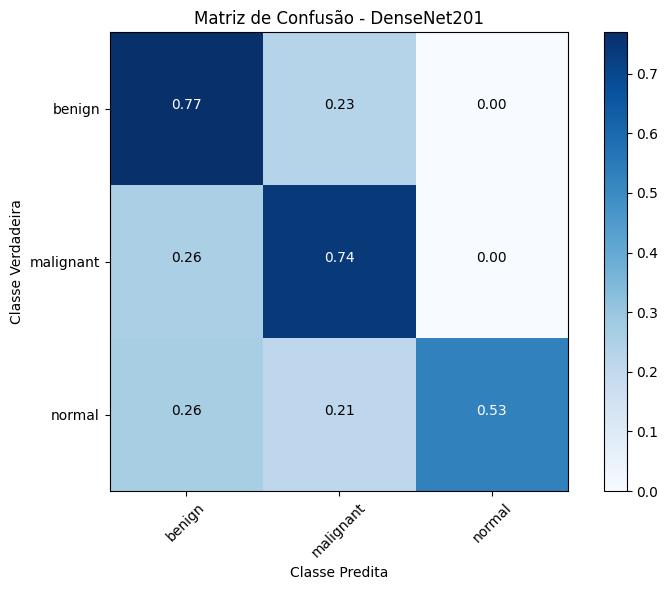

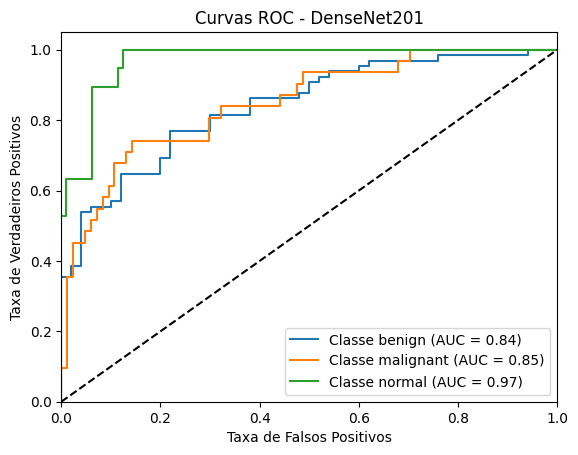

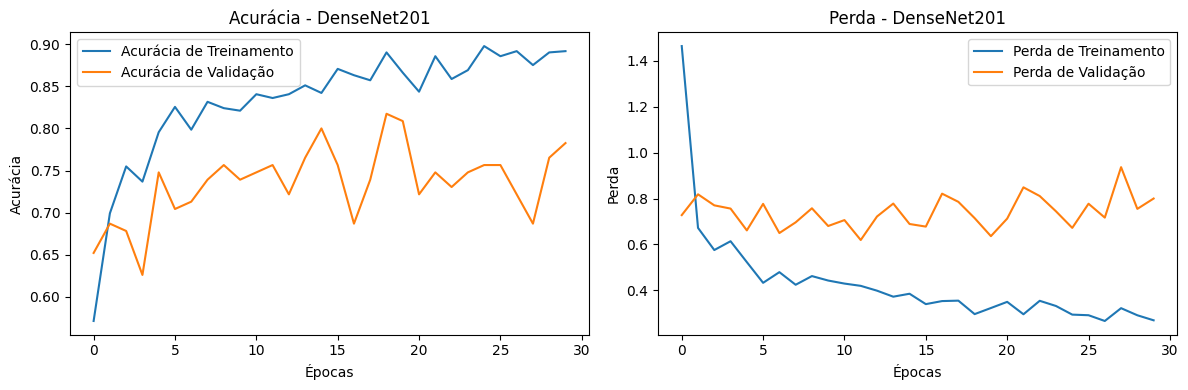

Matriz de Confusão Normalizada


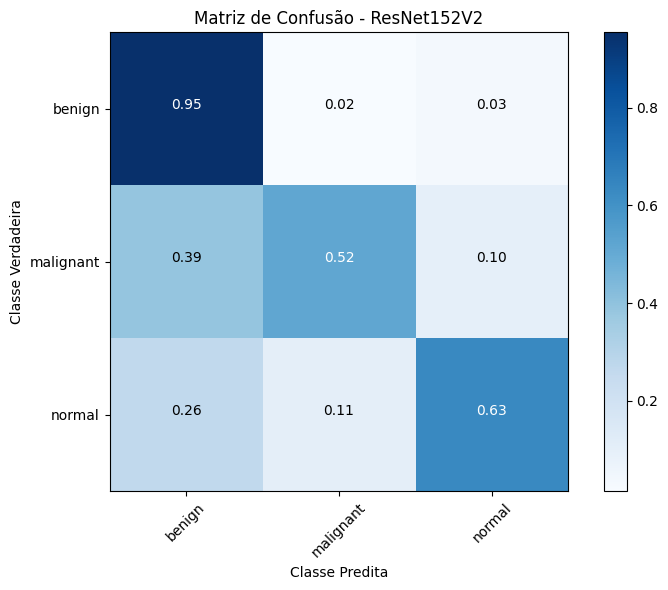

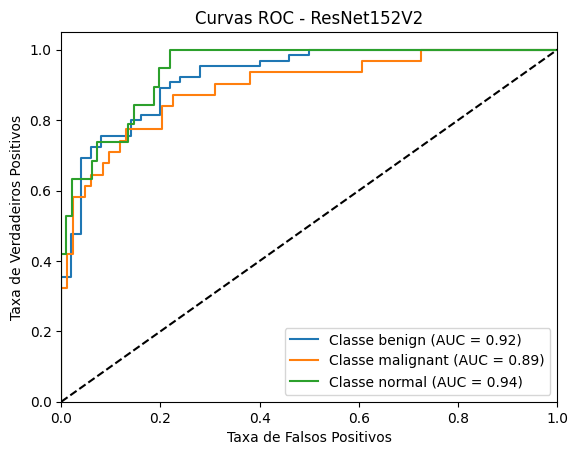

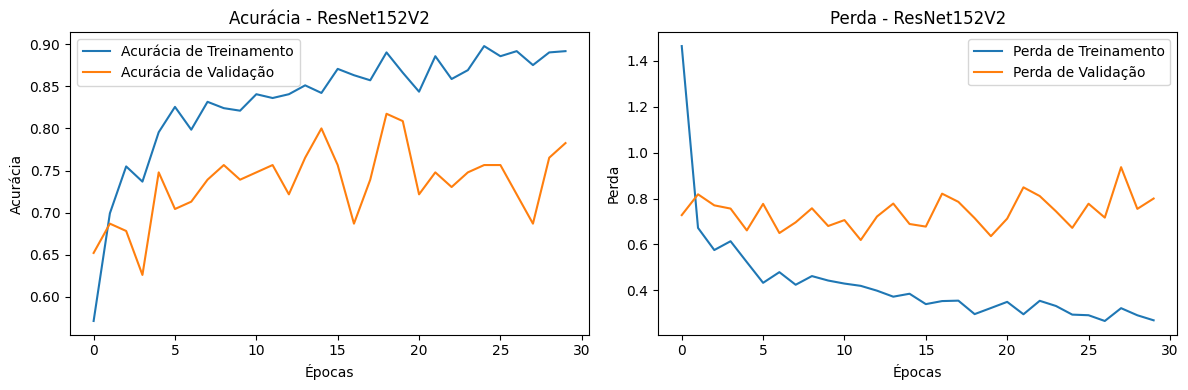

Matriz de Confusão Normalizada


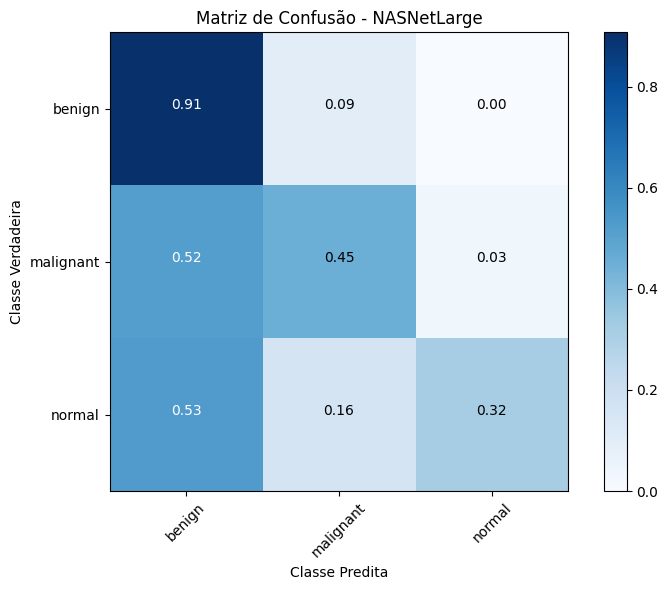

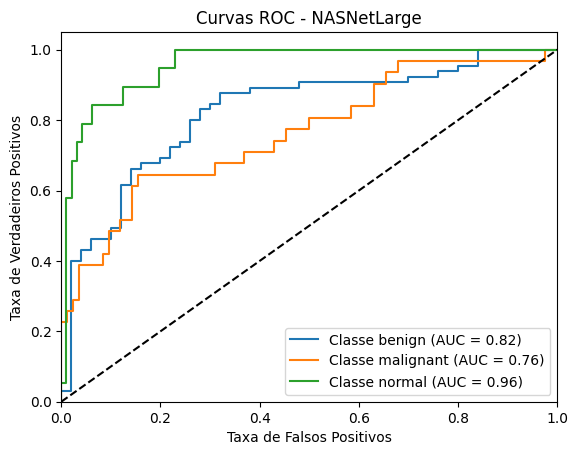

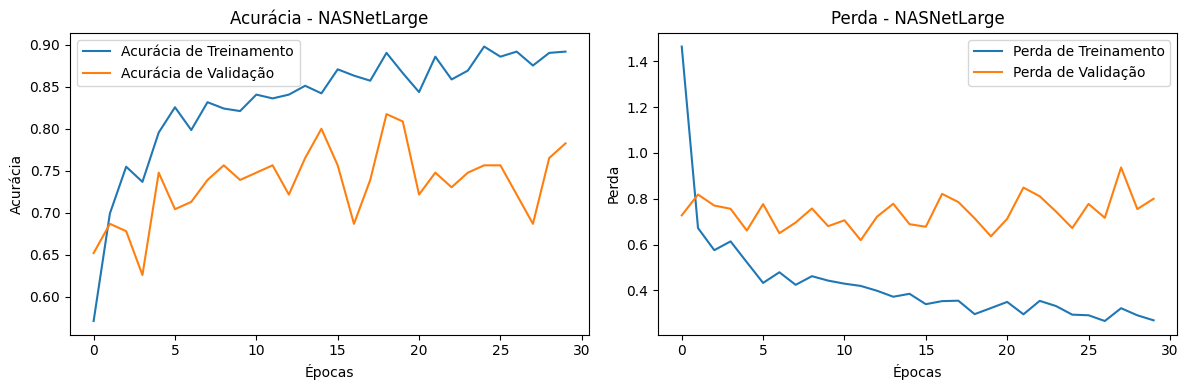

Matriz de Confusão Normalizada


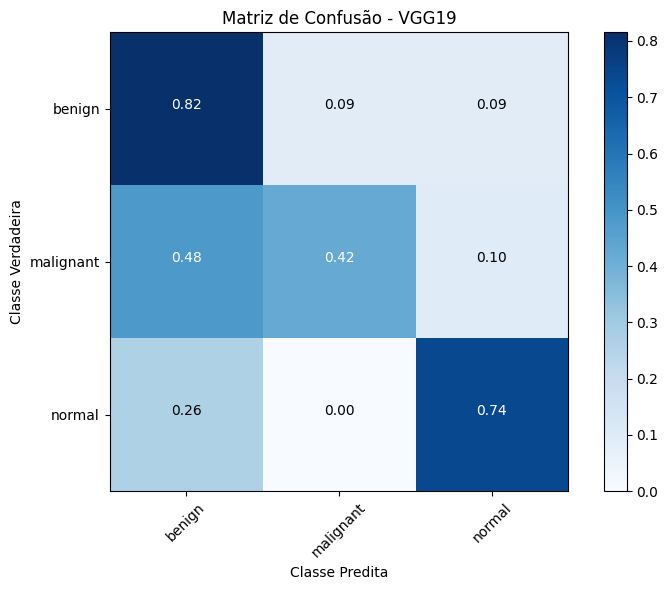

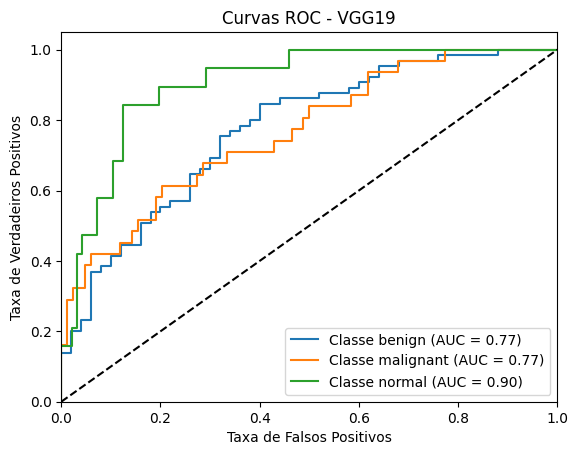

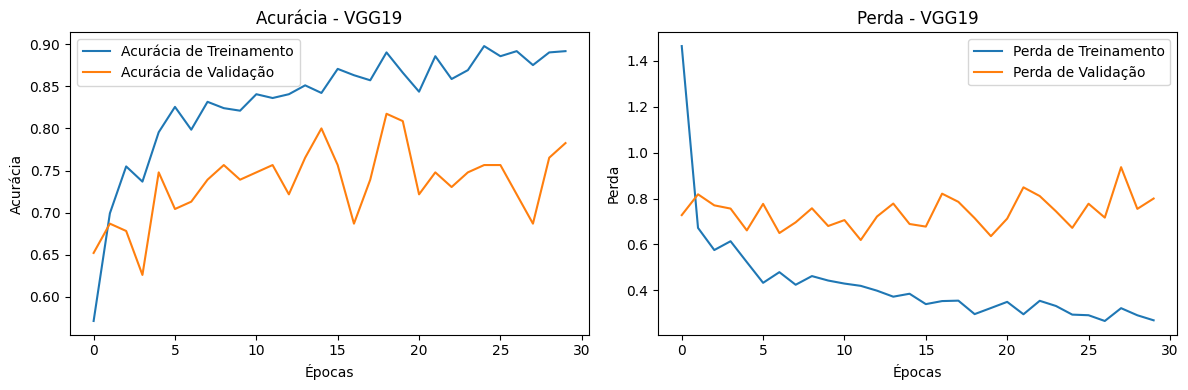

Matriz de Confusão Normalizada


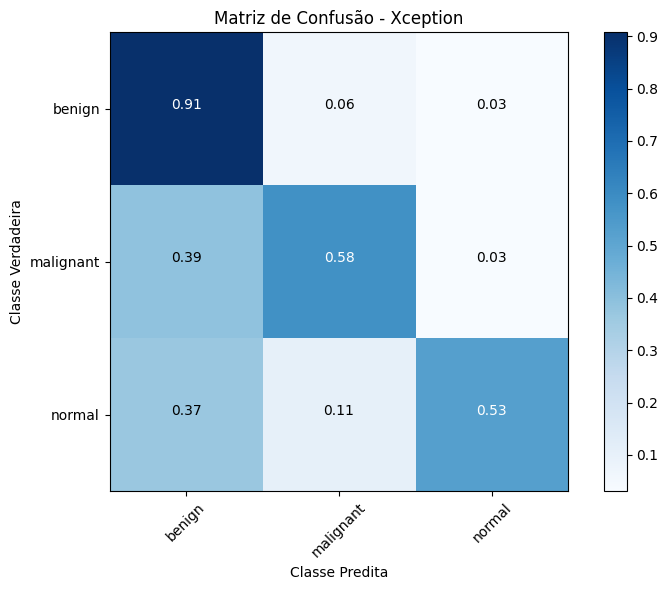

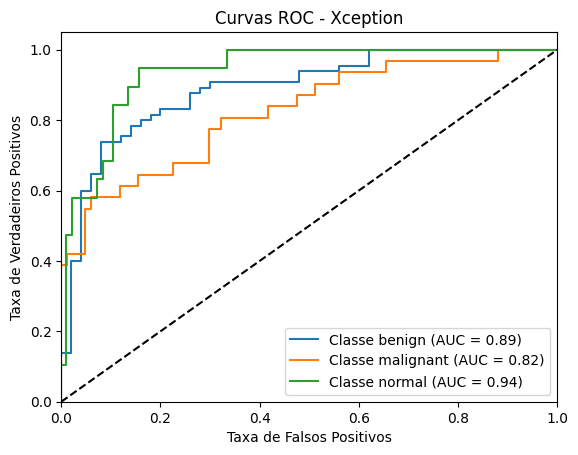

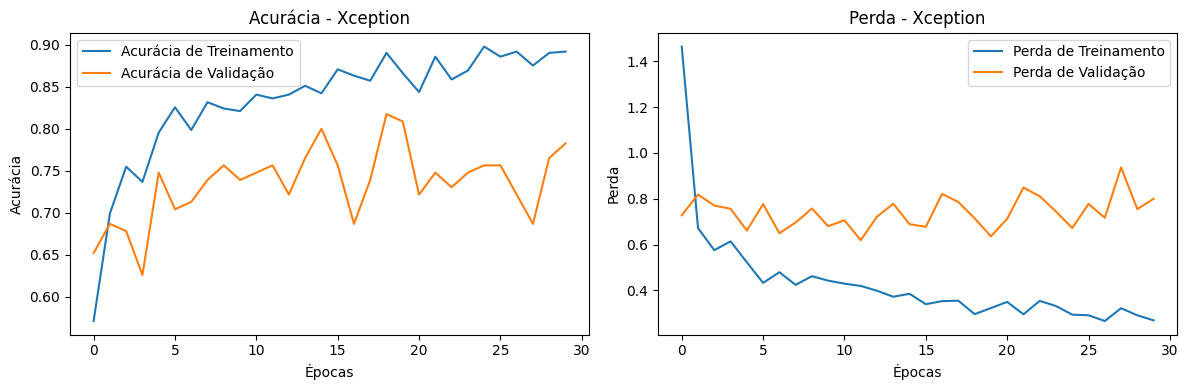

Matriz de Confusão Normalizada


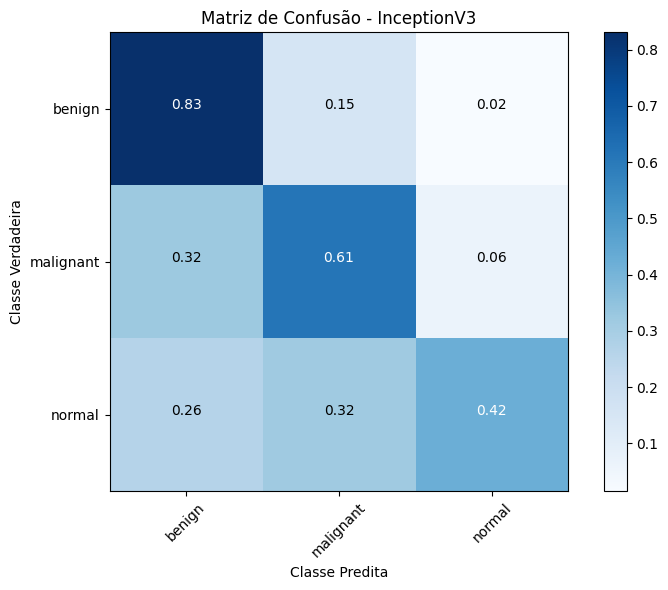

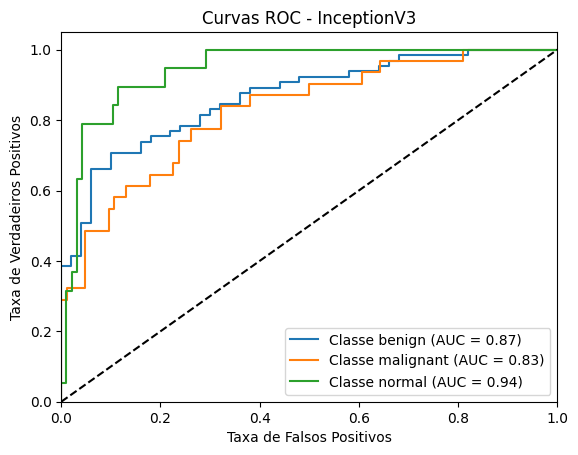

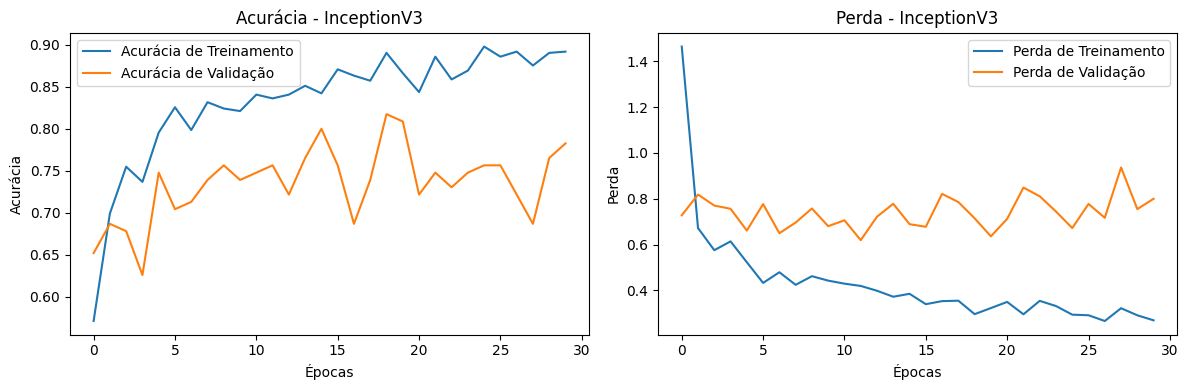

Matriz de Confusão Normalizada


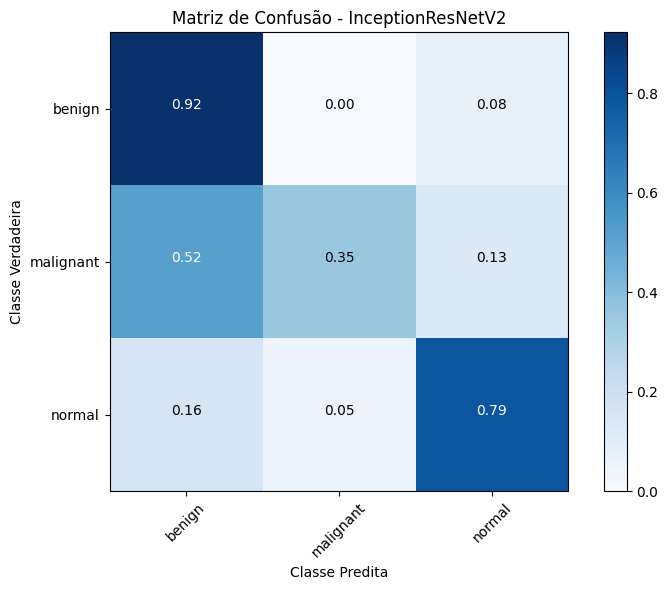

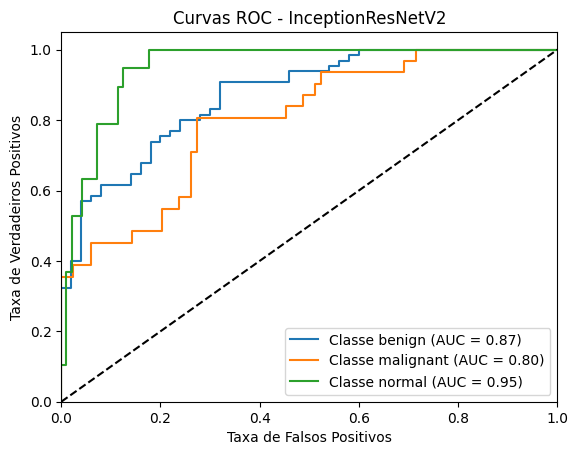

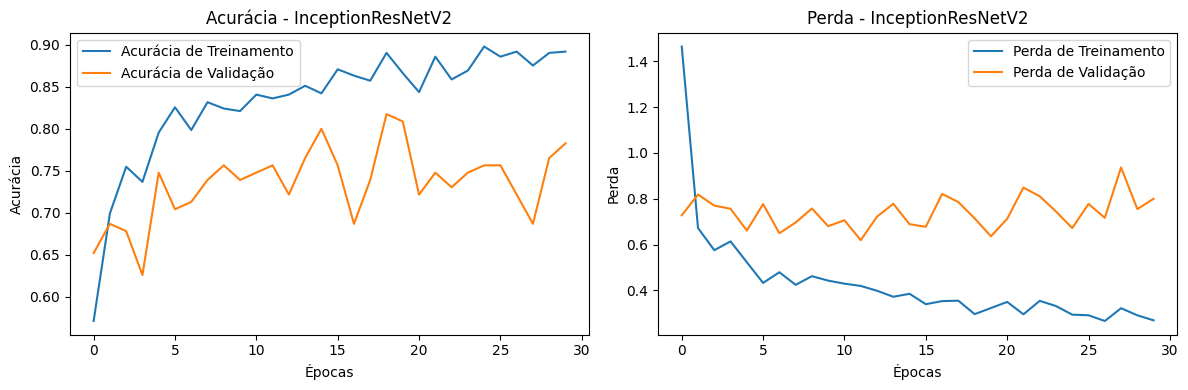

Matriz de Confusão Normalizada


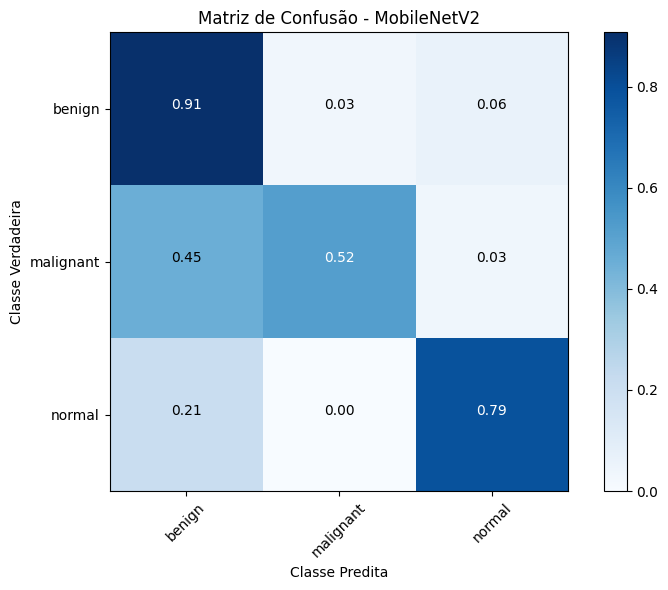

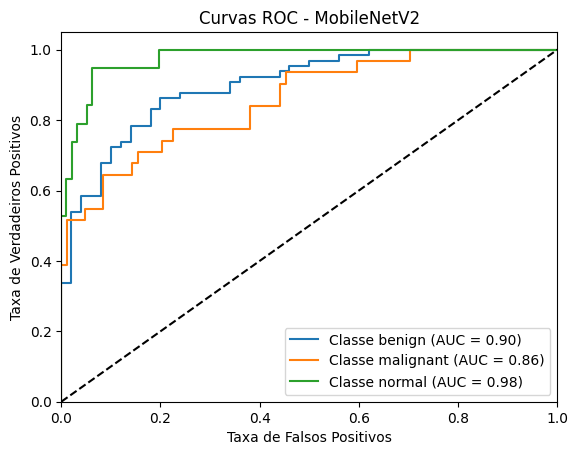

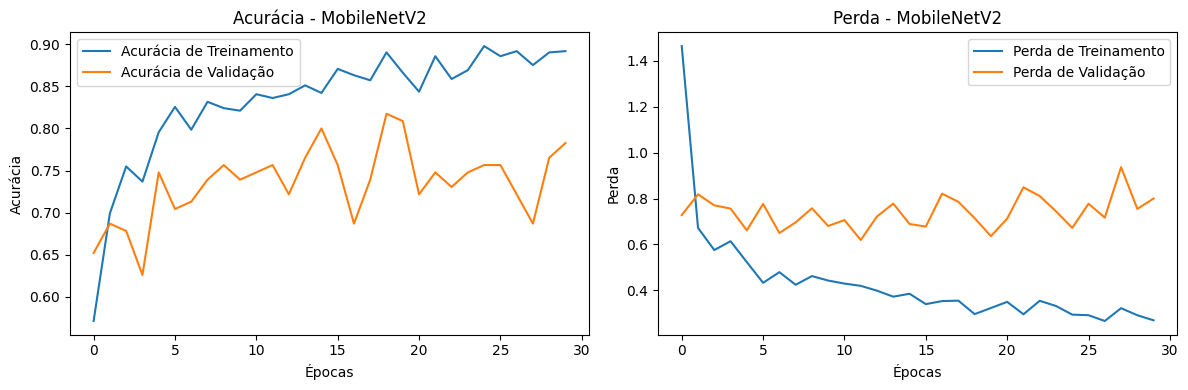

              Modelo  Acurácia Global  F1-Score Global  Tempo de Treino (s)  \
0        DenseNet201         0.721739         0.700347          1053.015961   
1        ResNet152V2         0.782609         0.722593          1229.464643   
2        NASNetLarge         0.686957         0.588908          4135.531794   
3              VGG19         0.695652         0.651594          1467.197286   
4           Xception         0.756522         0.701573          1474.496211   
5        InceptionV3         0.704348         0.638354           707.930618   
6  InceptionResNetV2         0.747826         0.680879          1401.992960   
7        MobileNetV2         0.782609         0.751093           340.216183   

   Tempo de Teste (s)  
0           10.103734  
1           10.560647  
2           27.626312  
3            7.595158  
4            8.397938  
5            5.900325  
6           11.873926  
7            3.086620  


In [12]:
# Criar um DataFrame para coletar as métricas globais
df_results = pd.DataFrame(columns=['Modelo', 'Acurácia Global', 'F1-Score Global', 'Tempo de Treino (s)', 'Tempo de Teste (s)'])

results_list = []

for result in results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Acurácia global
    accuracy = report['accuracy']
    # F1-Score global (calculado como a média dos F1-Scores das classes)
    f1_score = np.mean([report[label]['f1-score'] for label in class_labels])
    
    # Adicionar ao DataFrame
    results_list.append({
        'Modelo': model_name,
        'Acurácia Global': accuracy,
        'F1-Score Global': f1_score,
        'Tempo de Treino (s)': result['training_time'],
        'Tempo de Teste (s)': result['testing_time']
    })
    
    # Plotar a matriz de confusão
    plot_confusion_matrix(result['confusion_matrix'], classes=class_labels, model_name=model_name, normalize=True)
    
    # Plotar as curvas ROC
    plot_roc_curves(result['fpr'], result['tpr'], result['roc_auc'], class_labels, model_name)

    # Plotar a história de treinamento
    plot_training_history(history, model_name)

# Converter a lista de resultados em um DataFrame
df_results = pd.DataFrame(results_list)

# Exibir o DataFrame com os resultados
print(df_results)
df_results.to_csv('results.csv', index=False)

In [13]:
for result in results:
    model_name = result['model_name']
    report = result['classification_report']
    print(f"\nMétricas por classe para o modelo: {model_name}")
    for label in class_labels:
        print(f"Classe: {label}")
        print(f" - Precision: {report[label]['precision']:.4f}")
        print(f" - Recall: {report[label]['recall']:.4f}")
        print(f" - F1-score: {report[label]['f1-score']:.4f}")


Métricas por classe para o modelo: DenseNet201
Classe: benign
 - Precision: 0.7937
 - Recall: 0.7692
 - F1-score: 0.7812
Classe: malignant
 - Precision: 0.5476
 - Recall: 0.7419
 - F1-score: 0.6301
Classe: normal
 - Precision: 1.0000
 - Recall: 0.5263
 - F1-score: 0.6897

Métricas por classe para o modelo: ResNet152V2
Classe: benign
 - Precision: 0.7848
 - Recall: 0.9538
 - F1-score: 0.8611
Classe: malignant
 - Precision: 0.8421
 - Recall: 0.5161
 - F1-score: 0.6400
Classe: normal
 - Precision: 0.7059
 - Recall: 0.6316
 - F1-score: 0.6667

Métricas por classe para o modelo: NASNetLarge
Classe: benign
 - Precision: 0.6941
 - Recall: 0.9077
 - F1-score: 0.7867
Classe: malignant
 - Precision: 0.6087
 - Recall: 0.4516
 - F1-score: 0.5185
Classe: normal
 - Precision: 0.8571
 - Recall: 0.3158
 - F1-score: 0.4615

Métricas por classe para o modelo: VGG19
Classe: benign
 - Precision: 0.7260
 - Recall: 0.8154
 - F1-score: 0.7681
Classe: malignant
 - Precision: 0.6842
 - Recall: 0.4194
 - F1-sc